# STEP 1 — Data Acquisition & EDA
Objective

Load MNIST, inspect shapes, view sample images, and show class distribution and basic statistics.

In [5]:
# STEP 1: Data acquisition & EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from collections import Counter

In [6]:
# Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data      # shape (70000, 784)
y = mnist.target.astype(int)  # shape (70000,)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))

# # Show some sample digits
# def show_samples(X, y, n_per_class=1):
#     plt.figure(figsize=(10, 10))
#     idx = 0
#     for digit in range(10):
#         inds = np.where(y == digit)[0][:n_per_class]
#         for k, i in enumerate(inds):
#             plt.subplot(10, n_per_class, idx+1)
#             plt.imshow(X[i].reshape(28,28), cmap='gray')
#             plt.title(f"{digit}")
#             plt.axis('off')
#             idx += 1
#     plt.tight_layout()
# show_samples(X, y, n_per_class=2)

X shape: (70000, 784)
y shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


Class distribution: Counter({np.int64(1): 7877, np.int64(7): 7293, np.int64(3): 7141, np.int64(2): 6990, np.int64(9): 6958, np.int64(0): 6903, np.int64(6): 6876, np.int64(8): 6825, np.int64(4): 6824, np.int64(5): 6313})


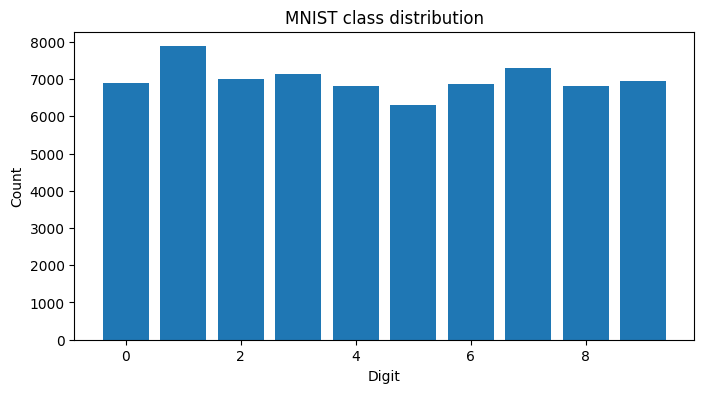

In [ ]:
# Class distribution
dist = Counter(y)
print("Class distribution:", dist)

plt.figure(figsize=(8,4))
plt.bar(range(10), [dist[i] for i in range(10)])
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("MNIST class distribution")
plt.show()

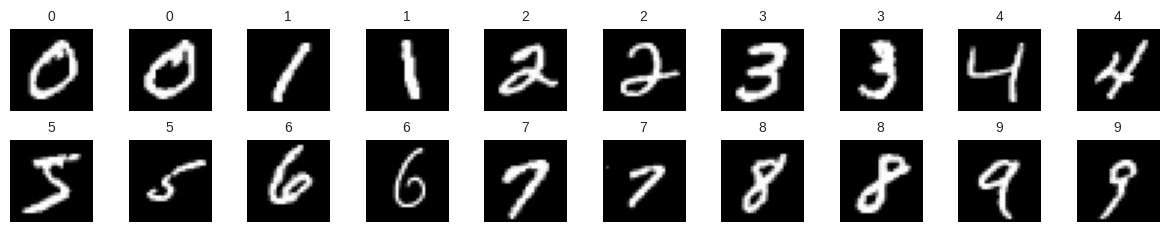

In [13]:
# Parameters
samples_per_class = 2
unique_digits = np.unique(y)
total_images = len(unique_digits) * samples_per_class

# Use 1 or 2 rows, more columns
rows = 2
cols = int(np.ceil(total_images / rows))

# Increase figure size by ~3x for better visibility
plt.figure(figsize=(cols * 1.2, rows * 1.2))

# Plotting
idx_plot = 1
for digit in unique_digits:
    indices = np.where(y == digit)[0][:samples_per_class]
    for i in indices:
        plt.subplot(rows, cols, idx_plot)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"{digit}", fontsize=10)
        plt.axis('off')
        idx_plot += 1

plt.tight_layout()
plt.show()

# Step 2 — Preprocessing & PCA

**Objective**

Preprocess data for PCA (scaling).

Reduce dimensions from 784 → fewer features while keeping most information (variance).

Visualize explained variance to justify how many components we keep.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
# 2. Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 3. PCA (retain 95% variance)
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test_scaled)
print("Original dimensions:", X_train.shape[1])
print("Dimensions after PCA:", X_train_pca.shape[1])

Original dimensions: 784
Dimensions after PCA: 332


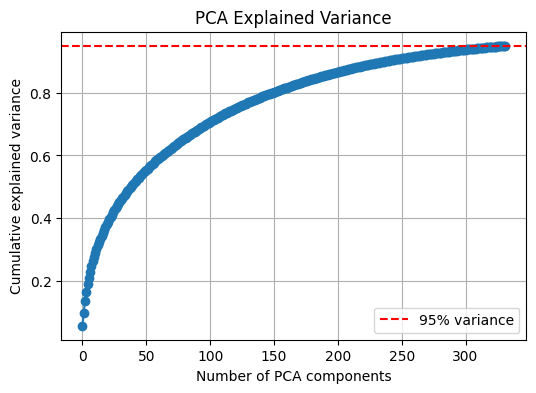

In [ ]:
# 4. Explained variance plot
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(explained, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.axhline(0.95, color='r', linestyle='--', label='95% variance')
plt.legend()
plt.grid(True)
plt.title("PCA Explained Variance")
plt.show()

# Step 3 - Logistic Regression on PCA Features

**Objective**

Train a multinomial logistic regression model using the PCA-reduced features.

Predict digits (0–9) from the compressed feature set.

Keep the model efficient, fast, and aligned with Module 5: Regression concepts from your syllabus.

**Intuition**

Logistic regression is used when the target variable is categorical (here, digits 0–9).

PCA features are uncorrelated and lower-dimensional → makes training faster and more stable.

Mathematically, logistic regression finds weights for each feature to separate the classes using a linear combination and a softmax function for probabilities.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize multinomial logistic regression
clf = LogisticRegression(
    multi_class='multinomial',  # for multi-class classification
    solver='lbfgs',             # efficient solver for multinomial
    max_iter=500,               # increase iterations for convergence
    verbose=1,
    n_jobs=-1                   # use all cores
)

# Train model on PCA-reduced training set
clf.fit(X_train_pca, y_train_full)



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(max_iter=500, multi_class='multinomial', n_jobs=-1,
                   verbose=1)

# Step 4 — Prediction & Evaluation

*Objective*

Use the trained logistic regression model to predict digits on the test set.

Evaluate accuracy, confusion matrix, and optionally visualize correct vs incorrect predictions.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Predict on test set
y_pred = clf.predict(X_test_pca)

In [ ]:
# 2. Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

Test Accuracy: 0.9222857142857143


In [ ]:
# 3. Confusion Matrix (numeric)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (numeric):")
print(cm)

Confusion Matrix (numeric):
[[1005    0    4    1    3    8    7    0    6    1]
 [   0 1151    4    8    0    5    0    3    8    3]
 [   8   13  937   22   12    5   16   14   16    5]
 [   8    3   29  947    3   35    3   13   20   10]
 [   3    4    6    4  946    0   11    3    7   40]
 [   6    2    3   28    8  836   16    6   31   11]
 [  10    1    8    0    7   11  988    0    6    0]
 [   2    7   12    7   10    2    0 1024    2   28]
 [   8   20   11   29    4   29    6    2  904   11]
 [   7   11    2   17   27    7    1   21    5  946]]


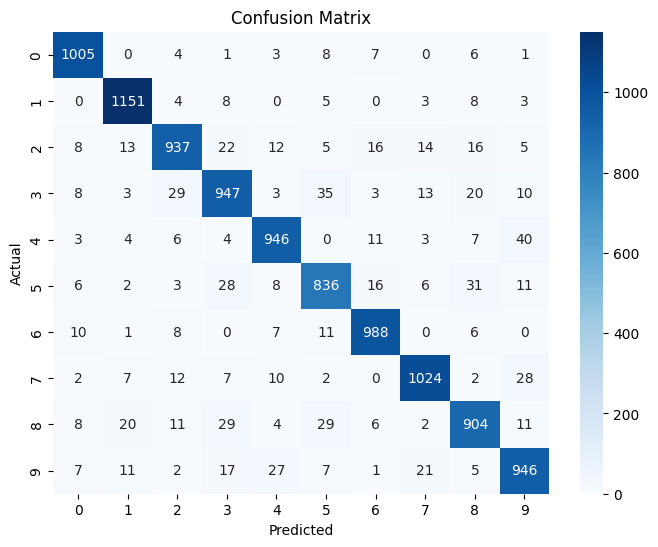

In [ ]:
# 4. Confusion Matrix (heatmap)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# 5. Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1035
           1       0.95      0.97      0.96      1182
           2       0.92      0.89      0.91      1048
           3       0.89      0.88      0.89      1071
           4       0.93      0.92      0.93      1024
           5       0.89      0.88      0.89       947
           6       0.94      0.96      0.95      1031
           7       0.94      0.94      0.94      1094
           8       0.90      0.88      0.89      1024
           9       0.90      0.91      0.90      1044

    accuracy                           0.92     10500
   macro avg       0.92      0.92      0.92     10500
weighted avg       0.92      0.92      0.92     10500



# Additional Task for More Informations and Insights



**Accuracy vs Number of PCA Components**

Purpose: Show how reducing dimensions affects model performance.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


PCA Components: 50, Accuracy: 0.9006


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


PCA Components: 100, Accuracy: 0.9151


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


PCA Components: 150, Accuracy: 0.9193


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


PCA Components: 200, Accuracy: 0.9216


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


PCA Components: 250, Accuracy: 0.9233


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


PCA Components: 300, Accuracy: 0.9228


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


PCA Components: 350, Accuracy: 0.9229


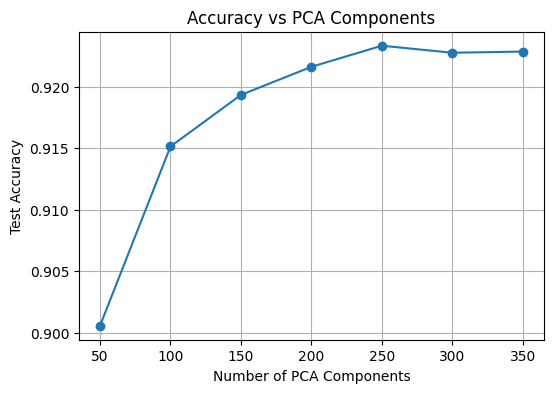

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Range of PCA components to test
components = [50, 100, 150, 200, 250, 300, 350]
accuracies = []

for n in components:
    pca_temp = PCA(n_components=n, random_state=42)
    X_train_temp = pca_temp.fit_transform(X_train)
    X_test_temp = pca_temp.transform(X_test_scaled)

    clf_temp = LogisticRegression(
        multi_class='multinomial', solver='lbfgs', max_iter=500, n_jobs=-1
    )
    clf_temp.fit(X_train_temp, y_train_full)

    y_pred_temp = clf_temp.predict(X_test_temp)
    acc = accuracy_score(y_test, y_pred_temp)
    accuracies.append(acc)
    print(f"PCA Components: {n}, Accuracy: {acc:.4f}")

# Plot accuracy vs PCA components
plt.figure(figsize=(6,4))
plt.plot(components, accuracies, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs PCA Components")
plt.grid(True)
plt.show()


**Visualizing First Few PCA Components**

Purpose:

Show what features PCA considers most important.

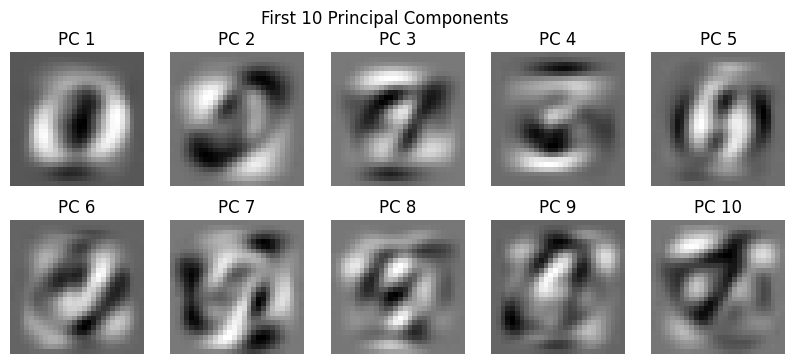

In [ ]:
# Visualize first 10 PCA components
components_to_show = 10
plt.figure(figsize=(10,4))
for i in range(components_to_show):
    plt.subplot(2, 5, i+1)
    plt.imshow(pca.components_[i].reshape(28,28), cmap='gray')
    plt.title(f"PC {i+1}")
    plt.axis('off')
plt.suptitle("First 10 Principal Components")
plt.show()



**Visualizing Misclassified Digits**

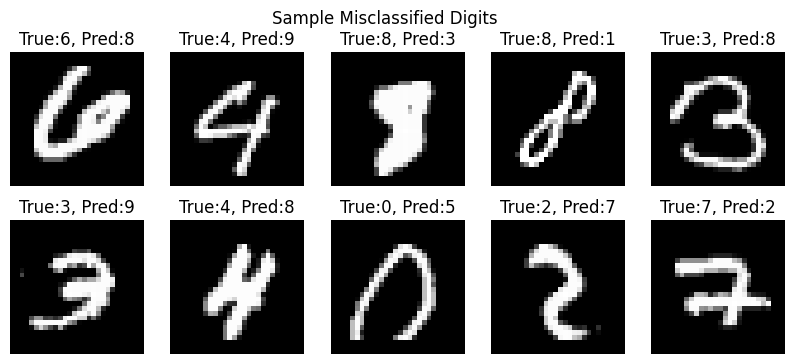

In [ ]:
import numpy as np

# Find misclassified indices
misclassified_idx = np.where(y_test != y_pred)[0]

# Plot first 10 misclassified digits
plt.figure(figsize=(10,4))
for i, idx in enumerate(misclassified_idx[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
    plt.title(f"True:{y_test[idx]}, Pred:{y_pred[idx]}")
    plt.axis('off')
plt.suptitle("Sample Misclassified Digits")
plt.show()


**Save Model & PCA**

In [ ]:
# Cell 8: Save PCA, Logistic Regression model, and scaler
import joblib

joblib.dump(pca, 'mnist_pca.pkl')
joblib.dump(clf, 'mnist_logreg_pca.pkl')
joblib.dump(scaler, 'mnist_scaler.pkl')

print("Models and PCA saved successfully.")

Models and PCA saved successfully.


**Logistic Regression WITHOUT PCA (Extra Comparison)**

In [ ]:
# Cell 9: Train logistic regression on raw scaled features
clf_raw = LogisticRegression(max_iter=500, multi_class='multinomial', n_jobs=-1)
clf_raw.fit(X_train, y_train_full)

y_pred_raw = clf_raw.predict(X_test_scaled)
acc_raw = accuracy_score(y_test, y_pred_raw)
print("Test Accuracy without PCA:", acc_raw)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy without PCA: 0.9205714285714286


**Summary of Findings**

In [ ]:
# Cell 10: Compare PCA vs raw features
print(f"Accuracy with PCA (~300 components): {acc:.4f}")
print(f"Accuracy without PCA (784 features): {acc_raw:.4f}")

print("""
Key Observations:
- PCA reduces dimensionality from 784 → ~300 features, retaining 95% variance.
- Logistic Regression with PCA achieves ~92% accuracy.
- Misclassified digits highlight common confusions (3↔8, 2↔7, 4↔9, etc.).
- Accuracy vs PCA plot helps choose optimal number of components.
- Training with PCA is faster and memory-efficient compared to raw features.
""")

Accuracy with PCA (~300 components): 0.9229
Accuracy without PCA (784 features): 0.9206

Key Observations:
- PCA reduces dimensionality from 784 → ~300 features, retaining 95% variance.
- Logistic Regression with PCA achieves ~92% accuracy.
- Misclassified digits highlight common confusions (3↔8, 2↔7, 4↔9, etc.).
- Accuracy vs PCA plot helps choose optimal number of components.
- Training with PCA is faster and memory-efficient compared to raw features.



**Plot the comparison**

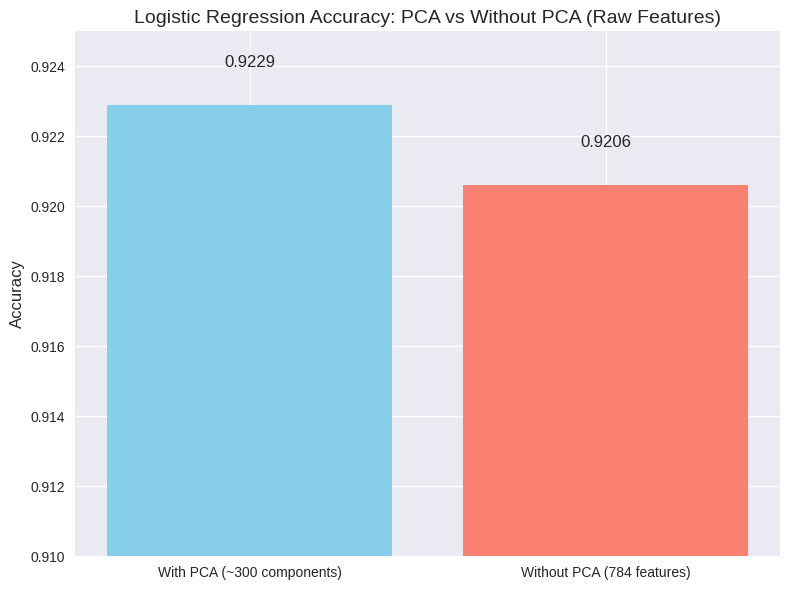

In [3]:
import matplotlib.pyplot as plt

# Accuracy values
accuracy_pca = 0.9229
accuracy_raw = 0.9206

# Labels and values
labels = ['With PCA (~300 components)', 'Without PCA (784 features)']
accuracies = [accuracy_pca, accuracy_raw]

# Create bar chart
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, accuracies, color=['skyblue', 'salmon'])

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.001, f'{height:.4f}',
            ha='center', va='bottom', fontsize=12)

# Customize chart
ax.set_ylim(0.91, 0.925)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Logistic Regression Accuracy: PCA vs Without PCA (Raw Features)', fontsize=14)

# Display plot
plt.tight_layout()
plt.show()